## Demo: Forcasting Stock Performance in Our Portfolio

This program retrieves stock price data using the Alpaca API and then simulates future performance using Monte Carlo Simulation.

### Import Dependencies

In [1]:
# Import libraries and dependencies
import os
import pandas as pd
import pathlib as Path
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
alpaca_api_key = "PKCOB2H0O22R019BIEH8"
alpaca_secret_key = "y0Nwg8WKvwxSGVadPNDXrWqRF1CONYpvAAOBwMFl"

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past 5 Year's Worth of Microsoft and Coca-Cola Stock Price Data via Alpaca API Call

In [4]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 3 years ago.
start_date = pd.Timestamp("2017-10-31", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-10-30", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["GOOGL", "MSFT", "JPM", "AMZN", "AAPL"]

# Get 3 year's worth of historical price data for Microsoft and Coca-Cola
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

df_ticker.index = df_ticker.index.tz_localize(None)


# Display sample data
df_ticker

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-10-31 04:00:00,167.900,169.6499,166.940,169.04,36070445,199384,168.609022,AAPL
2017-11-01 04:00:00,169.870,169.9400,165.610,166.89,33638072,209941,167.188415,AAPL
2017-11-02 04:00:00,167.640,168.5000,165.280,168.11,41394328,249912,168.444532,AAPL
2017-11-03 04:00:00,174.000,174.2600,171.120,172.50,59402471,336014,172.719018,AAPL
2017-11-06 05:00:00,172.365,174.9900,171.720,174.25,35026850,194183,173.981439,AAPL
...,...,...,...,...,...,...,...,...
2022-10-24 04:00:00,243.760,247.8400,241.295,247.25,25035516,321867,245.363795,MSFT
2022-10-25 04:00:00,247.260,251.0400,245.830,250.66,34775505,431898,247.914303,MSFT
2022-10-26 04:00:00,231.170,238.3000,230.060,231.32,82589077,977356,233.575597,MSFT


In [5]:
# Reorganize the DataFrame
# GOOGLSeparate ticker data
GOOGL = df_ticker[df_ticker['symbol']=='GOOGL'].drop('symbol', axis=1)
MSFT = df_ticker[df_ticker['symbol']=='MSFT'].drop('symbol', axis=1)
JPM = df_ticker[df_ticker['symbol']=='JPM'].drop('symbol', axis=1)
AMZN = df_ticker[df_ticker['symbol']=='AMZN'].drop('symbol', axis=1)
AAPL = df_ticker[df_ticker['symbol']=='AAPL'].drop('symbol', axis=1)

In [6]:
## Obtain bond data
# Read in the transaction_fraud_data.csv file into a PandasDataFrame.
BOND30 = pd.read_csv("../Resources/treasury_yield_30yr.csv")#, index_col='Date', infer_datetime_format=True, parse_dates=True)

BOND30 = BOND30.set_index('Date')

#BOND30 = BOND30.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])

# Review the DataFrame
BOND30

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-31,2.878,2.886,2.870,2.875,2.875,0.0
2017-11-01,2.897,2.899,2.837,2.862,2.862,0.0
2017-11-02,2.848,2.856,2.822,2.829,2.829,0.0
2017-11-03,2.828,2.838,2.809,2.822,2.822,0.0
2017-11-05,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2022-10-25,4.320,4.334,4.225,4.263,4.263,0.0
2022-10-26,4.198,4.215,4.143,4.163,4.163,0.0
2022-10-27,4.179,4.190,4.060,4.092,4.092,0.0


In [7]:
# Concatenate the ticker DataFrames
df_ticker = pd.concat([GOOGL, MSFT, JPM, AMZN, AAPL], axis=1, keys=["GOOGL", "MSFT", "JPM", "AMZN", "AAPL"])

# Display sample data
df_ticker

GOOGL                                         \
                         open     high       low     close    volume   
timestamp                                                              
2017-10-31 04:00:00  1033.000  1041.00  1026.295  1033.040   1516298   
2017-11-01 04:00:00  1036.315  1047.86  1034.000  1042.595   2163073   
2017-11-02 04:00:00  1039.990  1045.52  1028.660  1042.970   1334697   
2017-11-03 04:00:00  1042.750  1050.66  1037.650  1049.990   1389021   
2017-11-06 05:00:00  1049.100  1052.59  1042.000  1042.680    914748   
...                       ...      ...       ...       ...       ...   
2022-10-24 04:00:00   101.800   102.75    99.980   102.520  27169138   
2022-10-25 04:00:00   102.900   104.82   102.720   104.480  40615875   
2022-10-26 04:00:00    96.430    98.31    94.690    94.930  88142531   
2022-10-27 04:00:00    94.520    95.43    91.800    92.220  60710859   
2022-10-28 04:00:00    92.270    96.55    92.130    96.290  43651033   

                                                MSFT                    ...  \
                    trade_count         vwap    open    high       low  ...   
timestamp                                                               ...   
2017-10-31 04:00:00       30586  1033.150814   84.36   84.36   83.1100  ...   
2017-11-01 04:00:00       43079  1043.132132   83.68   83.76   82.8800  ...   
2017-11-02 04:00:00       28946  1039.206287   83.35   84.46   83.1200  ...   
2017-11-03 04:00:00       26960  1046.525289   84.08   84.54   83.4000  ...   
2017-11-06 05:00:00       22047  1046.364498   84.20   84.70   84.0825  ...   
...                         ...          ...     ...     ...       ...  ...   
2022-10-24 04:00:00      290904   101.763151  243.76  247.84  241.2950  ...   
2022-10-25 04:00:00      413280   102.890757  247.26  251.04  245.8300  ...   
2022-10-26 04:00:00      931642    96.282693  231.17  238.30  230.0600  ...   
2022-10-27 04:00:00      717132    92.949686  231.04  233.69  225.7800  ...   
2022-10-28 04:00:00      416408    94.771632  226.24  236.60  226.0500  ...   

                          AMZN                              AAPL            \
                        volume trade_count         vwap     open      high   
timestamp                                                                    
2017-10-31 04:00:00    3476968       55945  1105.775876  167.900  169.6499   
2017-11-01 04:00:00    3755927       62863  1102.417730  169.870  169.9400   
2017-11-02 04:00:00    3684876       61153  1094.569939  167.640  168.5000   
2017-11-03 04:00:00    3752548       55799  1101.448691  174.000  174.2600   
2017-11-06 05:00:00    3381147       57479  1120.412429  172.365  174.9900   
...                        ...         ...          ...      ...       ...   
2022-10-24 04:00:00   49522735      492273   119.100718  147.185  150.2300   
2022-10-25 04:00:00   50954509      469717   120.172043  150.090  152.4900   
2022-10-26 04:00:00   68942548      644558   116.357401  150.960  151.9900   
2022-10-27 04:00:00  129653465     1337218   105.597291  148.070  149.0460   
2022-10-28 04:00:00  222666614     1862227   100.762260  148.200  157.5000   

                                                                        
                        low   close     volume trade_count        vwap  
timestamp                                                               
2017-10-31 04:00:00  166.94  169.04   36070445      199384  168.609022  
2017-11-01 04:00:00  165.61  166.89   33638072      209941  167.188415  
2017-11-02 04:00:00  165.28  168.11   41394328      249912  168.444532  
2017-11-03 04:00:00  171.12  172.50   59402471      336014  172.719018  
2017-11-06 05:00:00  171.72  174.25   35026850      194183  173.981439  
...                     ...     ...        ...         ...         ...  
2022-10-24 04:00:00  146.00  149.45   75968735      652872  148.374492  
2022-10-25 04:00:00  149.36  152.34   74782289      581422  151.435017  
2022-10-26 0

### The MCForecastTools Library at a Glance

In [8]:
# Print the documentation of the MCSimulation module of the MCForecastTools library
?MCSimulation

Init signature:
MCSimulation(
    portfolio_data,
    weights='',
    num_simulation=1000,
    num_trading_days=252,
)
Docstring:     
A Python class for runnning Monte Carlo simulation on portfolio price data. 

...

Attributes
----------
portfolio_data : pandas.DataFrame
    portfolio dataframe
weights: list(float)
    portfolio investment breakdown
nSim: int
    number of samples in simulation
nTrading: int
    number of trading days to simulate
simulated_return : pandas.DataFrame
    Simulated data from Monte Carlo
confidence_interval : pandas.Series
    the 95% confidence intervals for simulated final cumulative returns
    
Init docstring:
Constructs all the necessary attributes for the MCSimulation object.

Parameters
----------
portfolio_data: pandas.DataFrame
    DataFrame containing stock price information from Alpaca API
weights: list(float)
    A list fractions representing percentage of total investment per stock. DEFAULT: Equal distribution
num_simulation: int
    Number 

### Simulate five year portfolio growth using Monte Carlo simulation

In [9]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_fiveyear = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.20,.20,.20,.20,.20],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [10]:
# Printing the simulation input data
MC_fiveyear.portfolio_data.head()

GOOGL                                        \
                         open     high       low     close   volume   
timestamp                                                             
2017-10-31 04:00:00  1033.000  1041.00  1026.295  1033.040  1516298   
2017-11-01 04:00:00  1036.315  1047.86  1034.000  1042.595  2163073   
2017-11-02 04:00:00  1039.990  1045.52  1028.660  1042.970  1334697   
2017-11-03 04:00:00  1042.750  1050.66  1037.650  1049.990  1389021   
2017-11-06 05:00:00  1049.100  1052.59  1042.000  1042.680   914748   

                                                            MSFT         ...  \
                    trade_count         vwap daily_return   open   high  ...   
timestamp                                                                ...   
2017-10-31 04:00:00       30586  1033.150814          NaN  84.36  84.36  ...   
2017-11-01 04:00:00       43079  1043.132132     0.009249  83.68  83.76  ...   
2017-11-02 04:00:00       28946  1039.206287     0.000360  83.35  84.46  ...   
2017-11-03 04:00:00       26960  1046.525289     0.006731  84.08  84.54  ...   
2017-11-06 05:00:00       22047  1046.364498    -0.006962  84.20  84.70  ...   

                            AMZN                  AAPL                    \
                            vwap daily_return     open      high     low   
timestamp                                                                  
2017-10-31 04:00:00  1105.775876          NaN  167.900  169.6499  166.94   
2017-11-01 04:00:00  1102.417730    -0.001448  169.870  169.9400  165.61   
2017-11-02 04:00:00  1094.569939    -0.008571  167.640  168.5000  165.28   
2017-11-03 04:00:00  1101.448691     0.015883  174.000  174.2600  171.12   
2017-11-06 05:00:00  1120.412429     0.008150  172.365  174.9900  171.72   

                                                                            
                      close    volume trade_count        vwap daily_return  
timestamp                                                                   
2017-10-31 04:00:00  169.04  36070445      199384  168.609022          NaN  
2017-11-01 04:00:00  166.89  33638072      209941  167.188415    -0.012719  
2017-11-02 04:00:00  168.11  41394328      249912  168.444532     0.007310  
2017-11-03 04:00:00  172.50  59402471      336014  172.719018     0.026114  
2017-11-06 05:00:00  174.25  35026850      194183  173.981439     0.010145  

[5 rows x 40 columns]

In [11]:
# Running a Monte Carlo simulation to forecast five years cumulative returns
MC_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/warrendenetsosie/Desktop/FinTech/Project_Two/Financial Analysis Notebooks/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992061,1.025261,0.994715,0.995190,1.001843,1.003102,0.999216,1.010308,0.999671,1.019104,...,1.008479,0.999793,1.005734,0.978904,1.001342,1.023311,1.001545,1.015932,0.987760,0.993400
2,0.988910,1.019057,1.001412,0.984892,1.034619,0.982315,0.998376,1.029531,1.008956,1.007420,...,1.029552,1.000794,1.006906,0.975171,1.006582,1.037943,1.014134,1.030959,0.984696,0.990479
3,0.999344,1.008905,0.998840,0.972464,1.035698,0.972434,0.989957,1.026655,0.994217,1.011387,...,1.025778,1.002612,0.997722,0.972290,1.013206,1.043808,1.007928,1.041492,0.978062,1.008385
4,0.999801,0.974944,1.005581,0.977106,1.027629,0.985965,0.990699,1.044582,0.989158,1.004789,...,1.031176,0.989744,0.991325,0.971250,1.017351,1.030126,1.008414,1.058071,0.984758,1.009952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2.187649,1.928015,1.378918,1.485394,1.269239,0.873277,1.525946,1.940765,1.379462,1.024553,...,1.933238,1.131095,1.510355,0.686143,1.789724,1.530976,0.931745,2.233398,0.695425,1.636648
1257,2.182442,1.917652,1.394503,1.467228,1.287217,0.871200,1.536464,1.953187,1.395182,1.030376,...,1.928343,1.144032,1.506258,0.685713,1.824899,1.522632,0.934295,2.252913,0.686321,1.620975
1258,2.160809,1.874484,1.403925,1.464268,1.240141,0.873675,1.514863,1.950623,1.380040,1.033380,...,1.900314,1.139757,1.508616,0.674975,1.832049,1.510851,0.921721,2.283348,0.687888,1.621980
1259,2.195740,1.848943,1.414207,1.477947,1.230707,0.880410,1.533493,1.931966,1.364965,1.041446,...,1.895210,1.161197,1.515264,0.674267,1.864200,1.528859,0.907676,2.304201,0.684798,1.644733


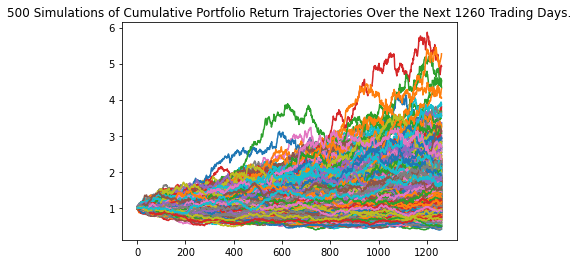

In [12]:
# Plot simulation outcomes
line_plot = MC_fiveyear.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_fiveyear_sim_plot.png", bbox_inches="tight")

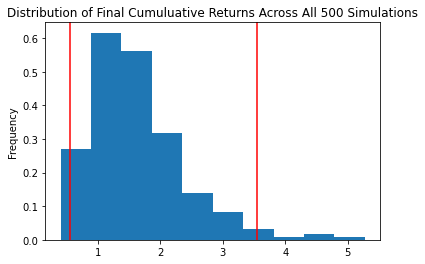

In [13]:
# Plot probability distribution and confidence intervals
dist_plot = MC_fiveyear.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight')

In [14]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_fiveyear.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              1.630194
std               0.756414
min               0.406356
25%               1.094044
50%               1.493365
75%               2.010673
max               5.272285
95% CI Lower      0.565088
95% CI Upper      3.547699
Name: 1260, dtype: float64


In [15]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $10,000 investments in Coca-Cola and Microsoft stocks
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 5 years will end within in the range of $5650.88 and $35476.99
